[View in Colaboratory](https://colab.research.google.com/github/wayne1123/Topic/blob/master/PCA.ipynb)

In [0]:
#!kill -9 -1

## PCA

In this notebook, I am going to implement PCA using pytorch and torchvision. Though I use pytorch, I don't need to use GPU.

The purpose of PCA is to find the components explaining the largest variance of the original data. It can be used for dimension reduction.


In [2]:
!pip3 install torchvision

    100% |████████████████████████████████| 61kB 3.9MB/s 
    100% |████████████████████████████████| 2.0MB 7.8MB/s 
    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x590ee000 @  0x7fda83eed1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [3]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
False


In [0]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import Variable

Load the dataset using normaliszation function to make the MNIST dataset having zero mean and one standard deviation.

In [5]:
batch_size = 250
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=batch_size, shuffle=True, **kwargs)

Processing...
Done!


In [0]:
img = torch.zeros(60000,1,28,28)
lab = torch.zeros(60000,1)
#img = img.cuda()
for j, data in enumerate(train_loader):
  image, label = data
  #image = image.cuda()
  #print(image.size())
  img[batch_size*j:batch_size*(j+1)] = image
  lab[batch_size*j:batch_size*(j+1)] = label.reshape(-1,1)

In [13]:
torch.mean(img), torch.std(img)

(tensor(1.00000e-04 *
        -1.2829), tensor(1.0000))

Now, we check that the mean of the images is negligible, and the standard deviation of the images is 1.

### The basic structure of this algorithm

1) Compute the covariance matrix <br/>
2) Get the Eigenvalues / Eigenvectors from the covariance matrix. <br/>
3) Normalize the eigenvectors - now they are orthonormal vectors. <br/>
4) Find the index of k-largest eigenvalues, and sort the eigenvectors using the index <br/>
5) Using these corresponding eigenvectors, transform them to reproduce the original images.

### Using formulas

Find the eigenvalues $\lambda$ and sort them in the decending order. <br/>
$Xv = \lambda v$ <br/>

How to get eigenvalues and eigenvectors?
$Xv = \lambda v, (X-\lambda I)v = 0$<br/>
Zero is the trivial solution, so the determinant of $(X-\lambda I) = 0$. <br/>
Here, eigenvalue $\lambda$ is scale invariant, but eigenvectors can vary up to scales. We can choose eigenvectors having the Norm 1.

Now, we can decompose X into its principal factors.

$X = \sum_{\text{for all v}} X vv^T$ 

For dimension reduction, we can choose k eigenvectors which correspond to $\textit{k largest eigenvalues}$. 



### Applying to MNIST dataset

The first obstacle would be the tensor. How to compute the covariance matrix of the tensor? <br/>
For grey-scale image, it is not difficult. Just make it into 1-dimention vectors. Then, now there is a question. How about RGB scale images? <br/>

The second obstacle would be the number of images. Do we need to get PCA for every single images? or can we get PCA for overall, and extract the ten largest eigenvalues and corresponding eigenvectors then can we cluster the images successfully?

Think of MNIST vectors as 784 dimension vector. There are 60,000 number of 784 dimension vectors in the training set. Actually, they correspond to 10 different labels. In other words, it has 10 different clusters. 

Let's take 10 largest indexes of eigenvalues, and draw them to see if they figure out 10 different images.

In [55]:
img_r = img.reshape(-1, 784)
cov_r = torch.mm(img_r.permute(1,0), img_r)
val, vec = torch.symeig(cov_r, eigenvectors=True)
#val = val[:,0] # Taking only real parts
val_sorted, val_idx = torch.sort(val)
k=10
idx = val_idx[:k]
vec_k = vec[idx]
rep = torch.mm(cov_r,vec_k.permute(1,0))
print(torch.mean(rep),torch.std(rep))

tensor(-1.5243) tensor(14078.8887)


In [0]:
def draw(mm, k=1):
  for i in range(mm.shape[1]):
    plt.figure(figsize=(2,2))
    ax = plt.subplot(1,k,1)
    plt.imshow(mm[:,i].reshape(28,28))
    plt.axis('off')
    plt.show()

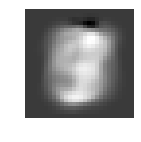

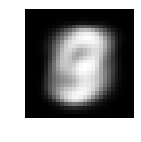

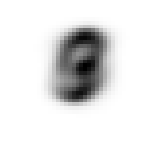

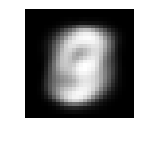

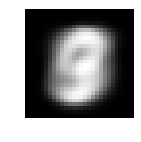

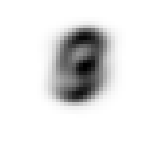

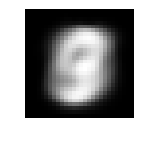

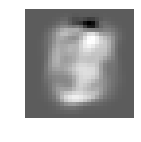

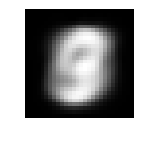

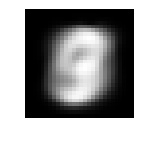

In [57]:
draw(rep)

It just finds the average of 10 different images. So, now do PCA using the label information. Take only the principal component.

In [0]:
k=1
pca = torch.zeros(784*k,10)
lab = lab.reshape(-1,)
for label in range(10):
  img_temp = img_r[lab==label]
  cov_temp = torch.mm(img_temp.permute(1,0),img_temp)
  val_temp, vec_temp = torch.symeig(cov_temp, eigenvectors=True)
  #val = val[:,0] # Taking only real parts
  val_sorted, val_idx = torch.sort(val_temp)
  idx = val_idx[:k]
  vec_k = vec_temp[idx]
  rep_ = torch.mm(cov_temp,vec_k.permute(1,0))
  pca[:,label] = rep_.reshape(-1,)

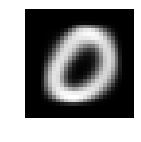

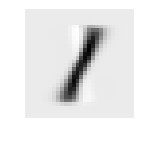

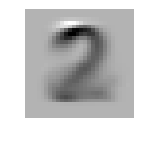

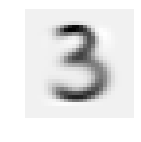

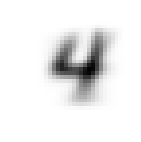

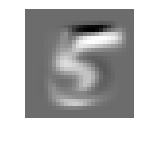

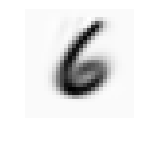

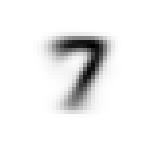

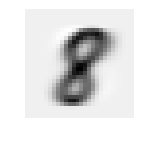

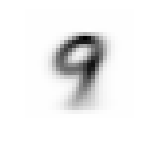

In [60]:
draw(pca,k)

It clearly shows that the principal component of MNIST data well describes the MNIST data set.

Future Work:
* How to cluster MNIST data without label information